In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.syn1neg.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_vocab_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_ngrams.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text
/kaggle/input/fasttext/__results__.html
/kaggle/input/fasttext/__notebook__.ipynb
/kaggle/input/fasttext/

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import FastText
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay
from pathlib import Path
import shutil

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Embedding Model Paths
scratch_path = "/kaggle/input/fasttext/scratch/scratch"
pretrained_path = "/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text"
finetuned_path = "/kaggle/input/fasttext/finetune/finetune"

FileExistsError: [Errno 17] File exists: 'custom_dataset'

In [3]:
# Loading the embedders
scratch = FastText.load(scratch_path)
pretrained = FastText.load(pretrained_path)
finetuned = FastText.load(finetuned_path)

print(pretrained.wv["ठोक"])

[ 7.61794001e-02 -4.92858231e-01  1.53381422e-01 -2.57078737e-01
  6.35857061e-02  1.04737259e-01  1.69516876e-01  1.93820685e-01
 -1.93721935e-01  1.77664801e-01  2.43365429e-02 -8.30003619e-02
 -2.54510194e-01 -4.06480692e-02 -8.65190253e-02 -6.49958327e-02
  2.22528175e-01  1.52424380e-01  2.54711863e-02  1.91342399e-01
  3.80364150e-01  1.16314612e-01 -1.11801457e-02  1.38561809e-02
 -3.27293165e-02  1.39722675e-01  1.29376486e-01  2.60515630e-01
  2.20912099e-01  1.68706372e-01 -4.08423722e-01 -3.22221816e-02
 -1.31672710e-01  3.94820757e-02  1.16161322e-02 -1.25651777e-01
  2.33733747e-02  8.31987783e-02  2.94195086e-01  1.63125563e-02
  6.76343814e-02 -3.16079706e-01 -1.25883310e-03  3.02024633e-01
 -7.36616179e-02 -2.25306731e-02  1.95028976e-01 -4.23262894e-01
 -1.73440307e-01  3.10934216e-01 -7.87678733e-02  1.86153263e-01
 -7.07686469e-02 -2.87645102e-01 -5.05212322e-02  2.34816104e-01
  1.28308073e-01  5.54363523e-03 -7.95640945e-02 -9.37999934e-02
  1.25269322e-02  2.42083

In [4]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


For fasttext model we cannot enter padsequence zero vector as sub word generation will create non-zero vector which contradicts our implementations on masking

In [5]:
# Using custom dataset to get vectors for our tokens
scratch_train = SequenceDataset(train["sentences"], binary=True, model=scratch, labels=train["labels"])
scratch_test = SequenceDataset(test["sentences"], binary=True, model=scratch, labels=test["labels"])
scratch_val = SequenceDataset(val["sentences"], binary=True, model=scratch, labels=val["labels"])

pretrained_train = SequenceDataset(train["sentences"], binary=True, model=pretrained, labels=train["labels"])
pretrained_test = SequenceDataset(test["sentences"], binary=True, model=pretrained, labels=test["labels"])
pretrained_val = SequenceDataset(val["sentences"], binary=True, model=pretrained, labels=val["labels"])

finetuned_train = SequenceDataset(train["sentences"], binary=True, model=finetuned, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=True, model=finetuned, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=True, model=finetuned, labels=val["labels"])



In [6]:
print(pretrained_val[0])
print(finetuned_test[0][0])

(tensor([[-0.2227, -0.1754, -0.0902,  ...,  0.3893,  0.0946,  0.3693],
        [-0.1171, -0.6463,  0.2926,  ..., -0.0579,  0.2198, -0.0643],
        [-0.0568, -0.2716,  0.0031,  ..., -0.0546,  0.0129,  0.4003],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [7]:
print(scratch_train[0][0].shape)

torch.Size([100, 300])


In [8]:
print(len(scratch_train))
print(len(scratch_test))

3765
471


In [9]:
# Setting up DataLoaders

scratch_train_loader = DataLoader(scratch_train, batch_size=16, shuffle=True, pin_memory=True)
scratch_test_loader = DataLoader(scratch_test, batch_size=16, shuffle=True, pin_memory=True)
scratch_val_loader = DataLoader(scratch_val, batch_size=16, shuffle=True, pin_memory=True)

pretrained_train_loader = DataLoader(pretrained_train, batch_size=16, shuffle=True, pin_memory=True)
pretrained_test_loader = DataLoader(pretrained_test, batch_size=16, shuffle=True, pin_memory=True)
pretrained_val_loader = DataLoader(pretrained_val, batch_size=16, shuffle=True, pin_memory=True)

finetuned_train_loader = DataLoader(finetuned_train, batch_size=16, shuffle=True, pin_memory=True)
finetuned_test_loader = DataLoader(finetuned_test, batch_size=16, shuffle=True, pin_memory=True)
finetuned_val_loader = DataLoader(finetuned_val, batch_size=16, shuffle=True, pin_memory=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
sequence_length, embeddings_size= scratch_train[0][0].shape
print(sequence_length)

100


## Model Definition

In [12]:
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,num_layers=1, batch_first=True, bidirectional=True)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * 2, 1) # since BiLSTM
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights

## Training Function

In [13]:
def model_train(model, criterion, optimizer, train_loader, val_loader, save_name=None, version_control=False, epochs=20):
    import matplotlib.pyplot as plt
    import copy

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_weights = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, mask, y_batch in train_loader:
            X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs, _ = model(X_batch, mask)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, mask, y_batch in val_loader:
                X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
                outputs, _ = model(X_batch, mask)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)
        val_accuracies.append(correct / total)

        # Update best model
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_epoch = epoch + 1 
            best_model_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accuracies[-1]*100:.2f}% | Val Acc: {val_accuracies[-1]*100:.2f}%")

    # Plotting with vertical dotted line for best epoch
    plt.figure(figsize=(14, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Loss: {best_val_loss:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
    plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best Epoch: {best_epoch}\nVal Acc: {val_accuracies[best_epoch-1]*100:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_loss.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model

## Training Model on Scratch Dataset

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
# 300 embeddings size with a hidden state output of 128 dim
scratch_model = BiLSTMAttention(input_dim=300, hidden_dim=148, num_classes=6).to(device)
scratch_criterion = nn.CrossEntropyLoss()
scratch_optimizer = torch.optim.AdamW(scratch_model.parameters(), lr=1e-4, weight_decay=1e-5)

print(scratch_model)
print(f"Trainable parameters: {count_parameters(scratch_model):,}")

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=6, bias=True)
)
Trainable parameters: 535,471


Epoch 1/20 | Train Loss: 1.1979 | Val Loss: 0.9503 | Train Acc: 55.14% | Val Acc: 65.61%
Epoch 2/20 | Train Loss: 0.8661 | Val Loss: 0.8588 | Train Acc: 68.21% | Val Acc: 69.43%
Epoch 3/20 | Train Loss: 0.7875 | Val Loss: 0.8596 | Train Acc: 71.87% | Val Acc: 68.79%
Epoch 4/20 | Train Loss: 0.7514 | Val Loss: 0.8219 | Train Acc: 72.56% | Val Acc: 71.13%
Epoch 5/20 | Train Loss: 0.7188 | Val Loss: 0.8181 | Train Acc: 74.53% | Val Acc: 70.91%
Epoch 6/20 | Train Loss: 0.6953 | Val Loss: 0.7878 | Train Acc: 75.67% | Val Acc: 71.97%
Epoch 7/20 | Train Loss: 0.6776 | Val Loss: 0.7831 | Train Acc: 75.91% | Val Acc: 71.34%
Epoch 8/20 | Train Loss: 0.6635 | Val Loss: 0.8059 | Train Acc: 75.83% | Val Acc: 72.61%
Epoch 9/20 | Train Loss: 0.6511 | Val Loss: 0.7744 | Train Acc: 77.40% | Val Acc: 73.25%
Epoch 10/20 | Train Loss: 0.6295 | Val Loss: 0.7899 | Train Acc: 77.37% | Val Acc: 73.67%
Epoch 11/20 | Train Loss: 0.6243 | Val Loss: 0.7913 | Train Acc: 77.93% | Val Acc: 73.25%
Epoch 12/20 | Train

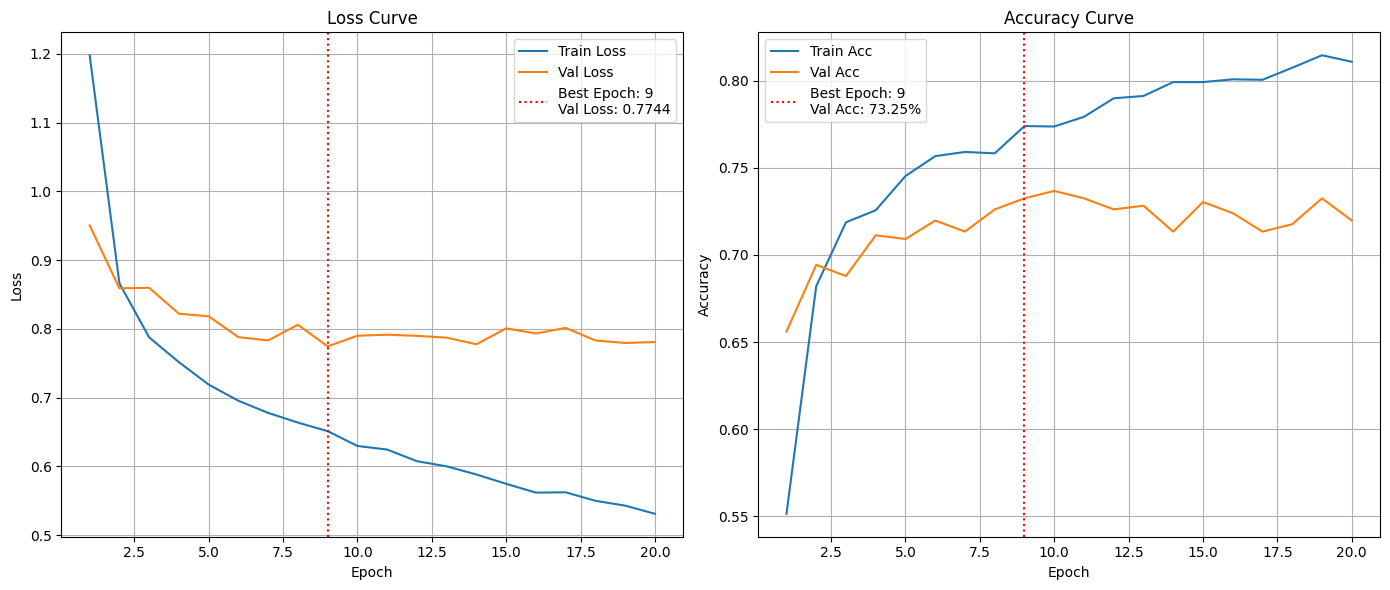

In [16]:
scratch_model = model_train(scratch_model, scratch_criterion, scratch_optimizer, scratch_train_loader, scratch_val_loader,epochs= 20)

In [17]:

def evaluate_model(model, test_loader, label_map=None, version_control= False, save_name = None):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, mask, y_batch in test_loader:
            X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device) 
            outputs, _ = model(X_batch, mask)
            probs = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # PR Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        avg_precision = average_precision_score(all_labels == i, all_probs[:, i])
        if not label_map:
            plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')
        else:
            plt.plot(recall, precision, label=f'{label_map[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Per-Class)')
    plt.legend(loc='upper right')
    plt.grid()
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_PR.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Confusion Matrix 
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    
    if not label_map:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    else:
        labels = [label_map[i] for i in sorted(label_map.keys())]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', pad=20, fontsize=14)
    
    # Rotate x-axis labels and adjust layout
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(rotation=0)
    plt.tight_layout() 
    plt.grid(False)
    plt.gca().set_facecolor('#f8f8f8')  
    if version_control:
        plt.savefig(f"/kaggle/working/{save_name}_cm.png", bbox_inches='tight', dpi=300)
    
    plt.show()

    if version_control:
        return classification_report(all_labels, all_preds, output_dict=True)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        87
           1       0.60      0.79      0.68       103
           2       0.77      0.70      0.73        94
           3       0.82      0.78      0.80        60
           4       0.68      0.74      0.71        61
           5       0.80      0.62      0.70        66

    accuracy                           0.73       471
   macro avg       0.75      0.73      0.74       471
weighted avg       0.75      0.73      0.73       471



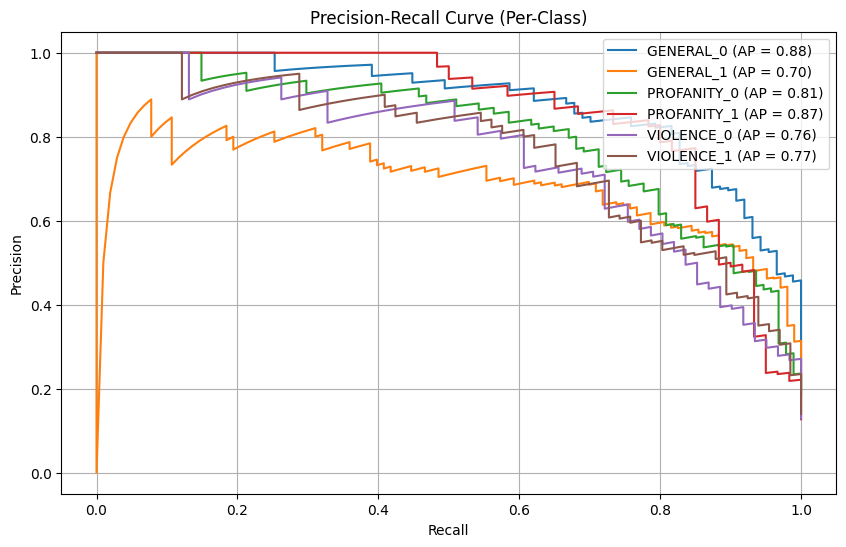

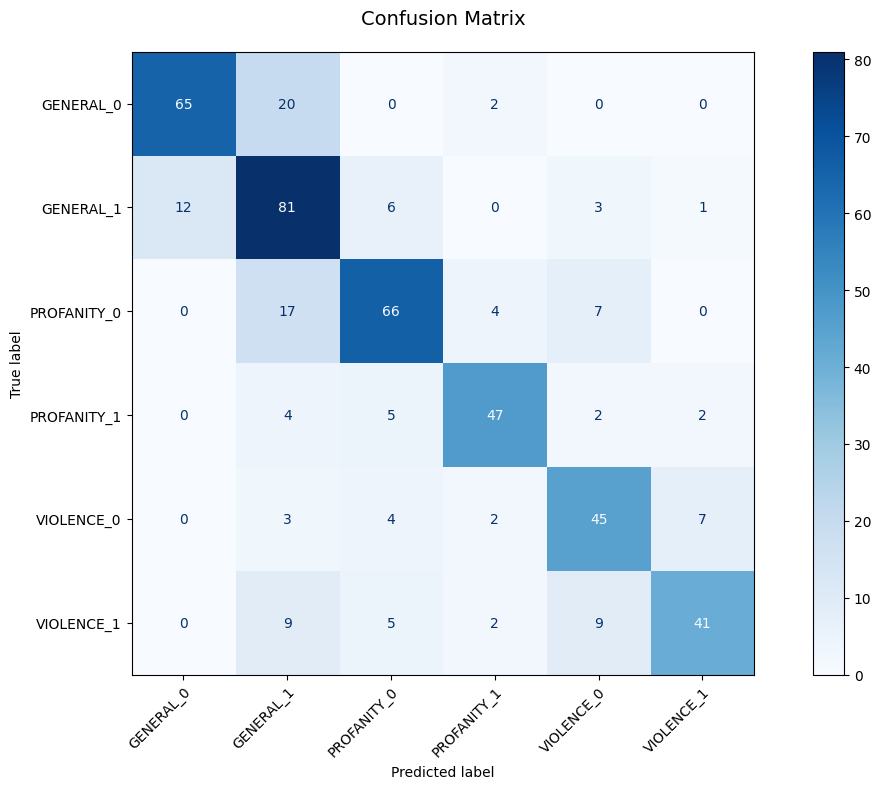

In [20]:
label_map = {
    0: 'GENERAL_0',
    1: 'GENERAL_1',
    2: 'PROFANITY_0',
    3: 'PROFANITY_1',
    4: 'VIOLENCE_0',
    5: 'VIOLENCE_1'
}
evaluate_model(scratch_model, scratch_val_loader, label_map)

## Verdict
Again for our task we will map the GENERAL and VIOLENCE labels as one. Our torch dataset is a map style dataset so we need to create a dataset class that maps the labels

In [21]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

scratch_train = LabelModifiedDataset(scratch_train)
scratch_test = LabelModifiedDataset(scratch_test)
scratch_val = LabelModifiedDataset(scratch_val)

pretrained_train = LabelModifiedDataset(pretrained_train)
pretrained_test = LabelModifiedDataset(pretrained_test)
pretrained_val = LabelModifiedDataset(pretrained_val)

finetuned_train = LabelModifiedDataset(finetuned_train)
finetuned_test = LabelModifiedDataset(finetuned_test)
finetuned_val = LabelModifiedDataset(finetuned_val)


In [23]:
# 300 embeddings size with a hidden state output of 128 dim
scratch_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

scratch_model = BiLSTMAttention(
    input_dim=scratch_params["input_dim"],
    hidden_dim=scratch_params["hidden_dim"],
    num_classes=scratch_params["num_classes"]
).to(device)

# Loss function
scratch_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
scratch_optimizer = torch.optim.AdamW(
    scratch_model.parameters(),
    lr=scratch_params["lr"],
    weight_decay=scratch_params["weight_decay"]
)

print(scratch_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


In [24]:
# Setting up DataLoaders using scratch_params
scratch_train_loader = DataLoader(scratch_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
scratch_test_loader  = DataLoader(scratch_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
scratch_val_loader   = DataLoader(scratch_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

pretrained_train_loader = DataLoader(pretrained_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
pretrained_test_loader  = DataLoader(pretrained_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
pretrained_val_loader   = DataLoader(pretrained_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

finetuned_train_loader = DataLoader(finetuned_train, batch_size=scratch_params["train_batch_size"], shuffle=True, pin_memory=True)
finetuned_test_loader  = DataLoader(finetuned_test,  batch_size=scratch_params["test_batch_size"],  shuffle=True, pin_memory=True)
finetuned_val_loader   = DataLoader(finetuned_val,   batch_size=scratch_params["val_batch_size"],   shuffle=True, pin_memory=True)

Epoch 1/20 | Train Loss: 0.7918 | Val Loss: 0.6157 | Train Acc: 68.98% | Val Acc: 77.07%
Epoch 2/20 | Train Loss: 0.5393 | Val Loss: 0.5922 | Train Acc: 80.69% | Val Acc: 79.19%
Epoch 3/20 | Train Loss: 0.5025 | Val Loss: 0.5745 | Train Acc: 82.55% | Val Acc: 80.68%
Epoch 4/20 | Train Loss: 0.4715 | Val Loss: 0.5812 | Train Acc: 83.32% | Val Acc: 80.89%
Epoch 5/20 | Train Loss: 0.4619 | Val Loss: 0.5420 | Train Acc: 83.32% | Val Acc: 81.74%
Epoch 6/20 | Train Loss: 0.4372 | Val Loss: 0.5481 | Train Acc: 84.83% | Val Acc: 81.74%
Epoch 7/20 | Train Loss: 0.4290 | Val Loss: 0.5546 | Train Acc: 84.67% | Val Acc: 81.74%
Epoch 8/20 | Train Loss: 0.4225 | Val Loss: 0.5150 | Train Acc: 85.58% | Val Acc: 82.17%
Epoch 9/20 | Train Loss: 0.4096 | Val Loss: 0.5642 | Train Acc: 85.79% | Val Acc: 81.32%
Epoch 10/20 | Train Loss: 0.4044 | Val Loss: 0.5240 | Train Acc: 86.06% | Val Acc: 82.38%
Epoch 11/20 | Train Loss: 0.4011 | Val Loss: 0.5346 | Train Acc: 86.32% | Val Acc: 81.10%
Epoch 12/20 | Train

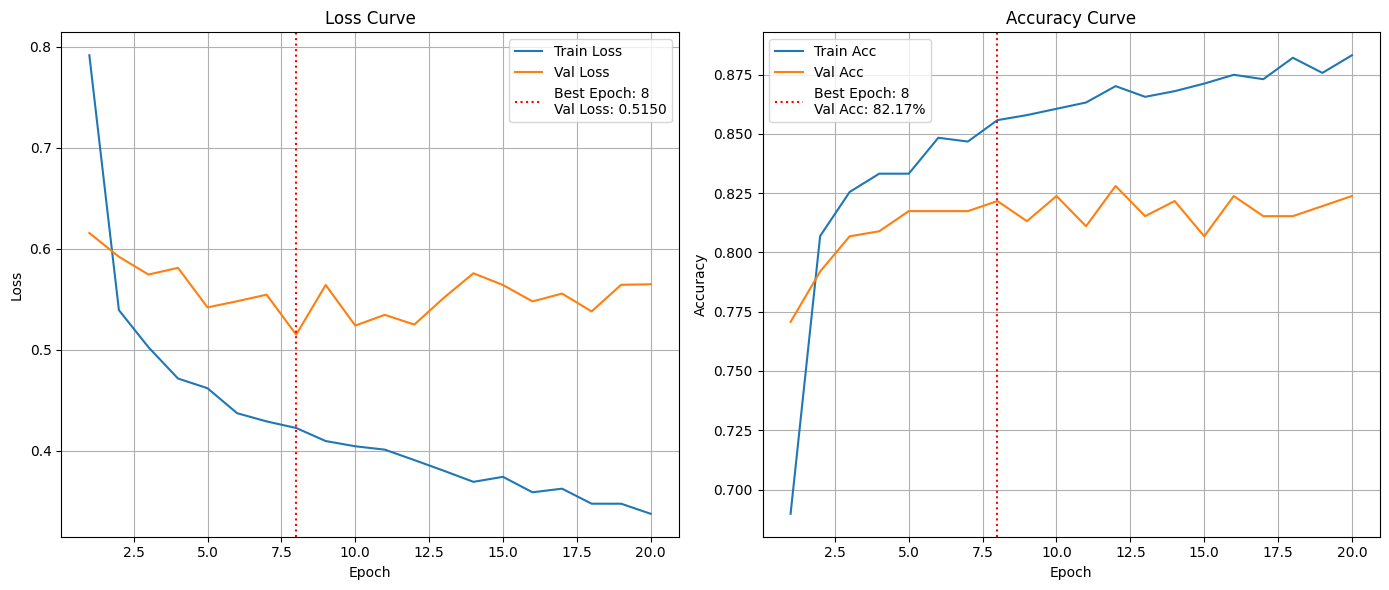

In [25]:
scratch_model = model_train(scratch_model, scratch_criterion, scratch_optimizer, scratch_train_loader, scratch_val_loader,save_name="fasttext_scratch", version_control=True,epochs= 20)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       190
           1       0.75      0.69      0.72        94
           2       0.84      0.70      0.76        60
           3       0.81      0.81      0.81       127

    accuracy                           0.82       471
   macro avg       0.81      0.78      0.80       471
weighted avg       0.82      0.82      0.82       471



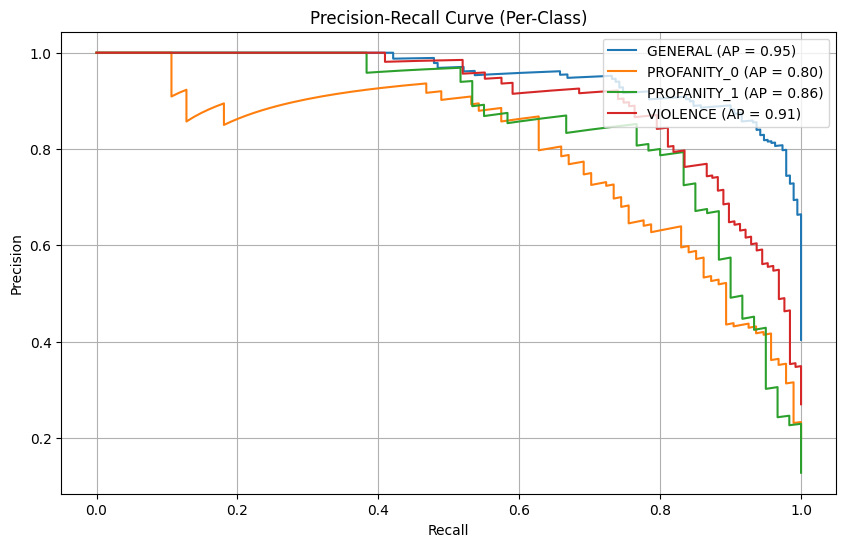

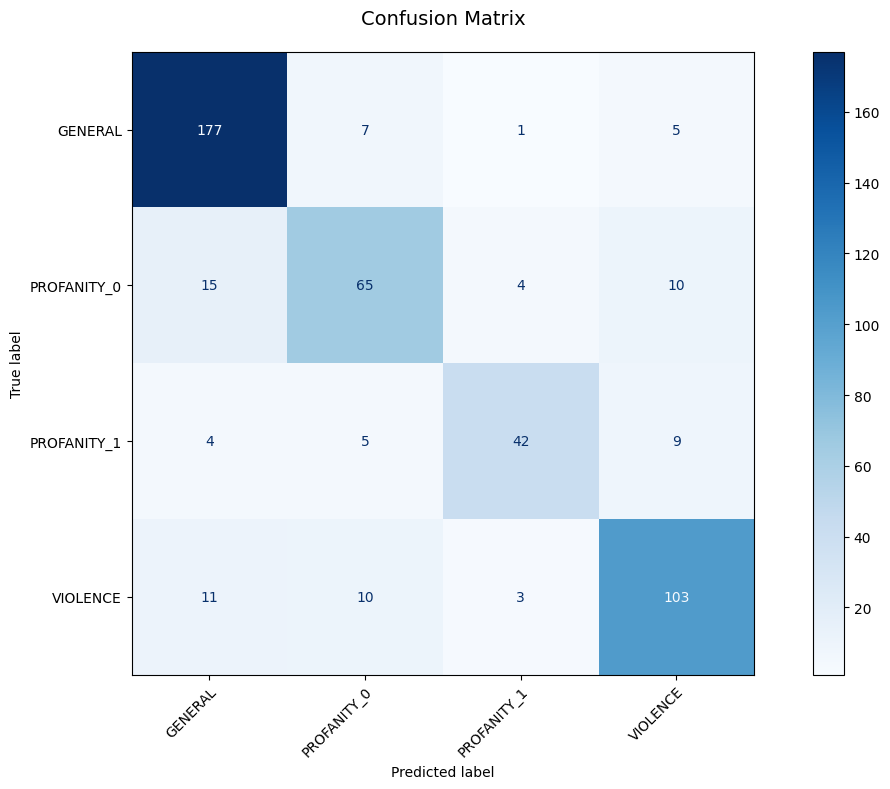

In [26]:
label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

scratch_report = evaluate_model(scratch_model, scratch_val_loader, label_map,  version_control= True, save_name = "fasttext_scratch")

In [28]:
scratch_report

{'0': {'precision': 0.855072463768116,
  'recall': 0.9315789473684211,
  'f1-score': 0.8916876574307304,
  'support': 190},
 '1': {'precision': 0.7471264367816092,
  'recall': 0.6914893617021277,
  'f1-score': 0.7182320441988951,
  'support': 94},
 '2': {'precision': 0.84,
  'recall': 0.7,
  'f1-score': 0.7636363636363636,
  'support': 60},
 '3': {'precision': 0.8110236220472441,
  'recall': 0.8110236220472441,
  'f1-score': 0.8110236220472442,
  'support': 127},
 'accuracy': 0.821656050955414,
 'macro avg': {'precision': 0.8133056306492422,
  'recall': 0.7835229827794482,
  'f1-score': 0.7961449218283083,
  'support': 471},
 'weighted avg': {'precision': 0.8197317477142532,
  'recall': 0.821656050955414,
  'f1-score': 0.8190077471013094,
  'support': 471}}

## Pre-trained Model

In [27]:
pretrained_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

pretrained_model = BiLSTMAttention(
    input_dim=pretrained_params["input_dim"],
    hidden_dim=pretrained_params["hidden_dim"],
    num_classes=pretrained_params["num_classes"]
).to(device)

# Loss function
pretrained_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
pretrained_optimizer = torch.optim.AdamW(
    pretrained_model.parameters(),
    lr=pretrained_params["lr"],
    weight_decay=pretrained_params["weight_decay"]
)

print(pretrained_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


Epoch 1/20 | Train Loss: 0.9340 | Val Loss: 1.3512 | Train Acc: 62.82% | Val Acc: 47.56%
Epoch 2/20 | Train Loss: 0.6224 | Val Loss: 1.9519 | Train Acc: 78.25% | Val Acc: 42.68%
Epoch 3/20 | Train Loss: 0.5276 | Val Loss: 2.1972 | Train Acc: 81.70% | Val Acc: 43.31%
Epoch 4/20 | Train Loss: 0.4646 | Val Loss: 2.3863 | Train Acc: 84.22% | Val Acc: 43.31%
Epoch 5/20 | Train Loss: 0.4319 | Val Loss: 2.7708 | Train Acc: 85.21% | Val Acc: 41.19%
Epoch 6/20 | Train Loss: 0.3879 | Val Loss: 2.7730 | Train Acc: 86.91% | Val Acc: 43.10%
Epoch 7/20 | Train Loss: 0.3684 | Val Loss: 2.9659 | Train Acc: 86.96% | Val Acc: 40.55%
Epoch 8/20 | Train Loss: 0.3337 | Val Loss: 3.2099 | Train Acc: 88.58% | Val Acc: 40.34%
Epoch 9/20 | Train Loss: 0.3211 | Val Loss: 3.2058 | Train Acc: 89.08% | Val Acc: 41.83%
Epoch 10/20 | Train Loss: 0.2972 | Val Loss: 3.2229 | Train Acc: 89.85% | Val Acc: 42.25%
Epoch 11/20 | Train Loss: 0.2825 | Val Loss: 3.2628 | Train Acc: 90.57% | Val Acc: 42.25%
Epoch 12/20 | Train

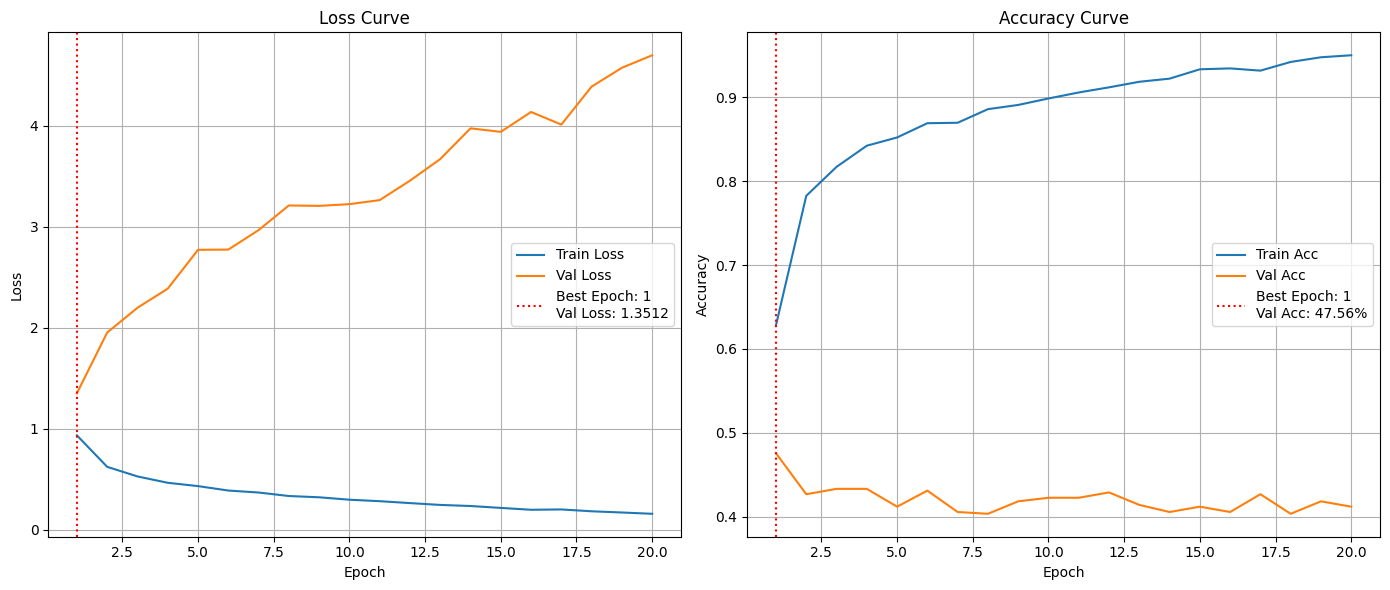

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       284
           1       0.09      0.12      0.10        60
           2       0.05      0.02      0.02       127
           3       0.00      0.00      0.00         0

    accuracy                           0.48       471
   macro avg       0.25      0.22      0.23       471
weighted avg       0.55      0.48      0.51       471



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No

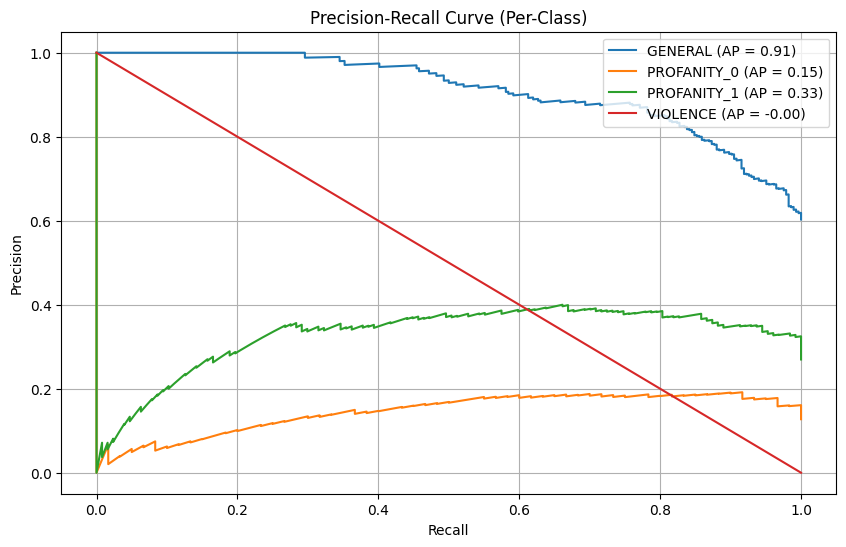

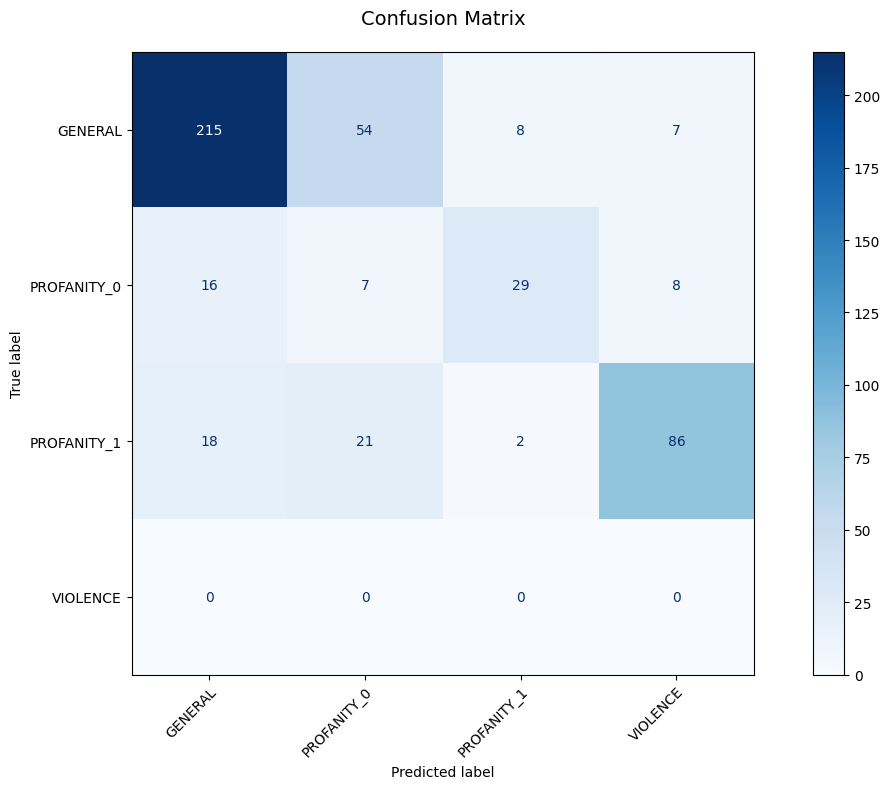

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
pretrained_model = model_train(pretrained_model, pretrained_criterion, pretrained_optimizer, pretrained_train_loader, pretrained_val_loader,save_name="fasttext_pretrained", version_control=True,epochs= 20)
pretrained_report = evaluate_model(pretrained_model, pretrained_val_loader, label_map,  version_control= True, save_name = "fasttext_pretrained")

## Finetuned Model

In [30]:
finetuned_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

finetuned_model = BiLSTMAttention(
    input_dim=finetuned_params["input_dim"],
    hidden_dim=finetuned_params["hidden_dim"],
    num_classes=finetuned_params["num_classes"]
).to(device)

# Loss function
finetuned_criterion = nn.CrossEntropyLoss()

# Optimizer using unpacking
finetuned_optimizer = torch.optim.AdamW(
    finetuned_model.parameters(),
    lr=finetuned_params["lr"],
    weight_decay=finetuned_params["weight_decay"]
)

print(finetuned_model)

BiLSTMAttention(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)


Epoch 1/20 | Train Loss: 0.9004 | Val Loss: 0.6272 | Train Acc: 63.48% | Val Acc: 75.16%
Epoch 2/20 | Train Loss: 0.5687 | Val Loss: 0.5291 | Train Acc: 79.20% | Val Acc: 80.04%
Epoch 3/20 | Train Loss: 0.4630 | Val Loss: 0.4764 | Train Acc: 83.77% | Val Acc: 83.65%
Epoch 4/20 | Train Loss: 0.4156 | Val Loss: 0.4520 | Train Acc: 85.37% | Val Acc: 85.56%
Epoch 5/20 | Train Loss: 0.3710 | Val Loss: 0.5457 | Train Acc: 87.04% | Val Acc: 83.23%
Epoch 6/20 | Train Loss: 0.3560 | Val Loss: 0.4322 | Train Acc: 87.81% | Val Acc: 85.35%
Epoch 7/20 | Train Loss: 0.3255 | Val Loss: 0.4588 | Train Acc: 89.19% | Val Acc: 84.71%
Epoch 8/20 | Train Loss: 0.3104 | Val Loss: 0.4370 | Train Acc: 89.06% | Val Acc: 86.20%
Epoch 9/20 | Train Loss: 0.2966 | Val Loss: 0.4658 | Train Acc: 90.60% | Val Acc: 85.35%
Epoch 10/20 | Train Loss: 0.2688 | Val Loss: 0.4675 | Train Acc: 90.65% | Val Acc: 85.56%
Epoch 11/20 | Train Loss: 0.2523 | Val Loss: 0.5351 | Train Acc: 92.11% | Val Acc: 85.35%
Epoch 12/20 | Train

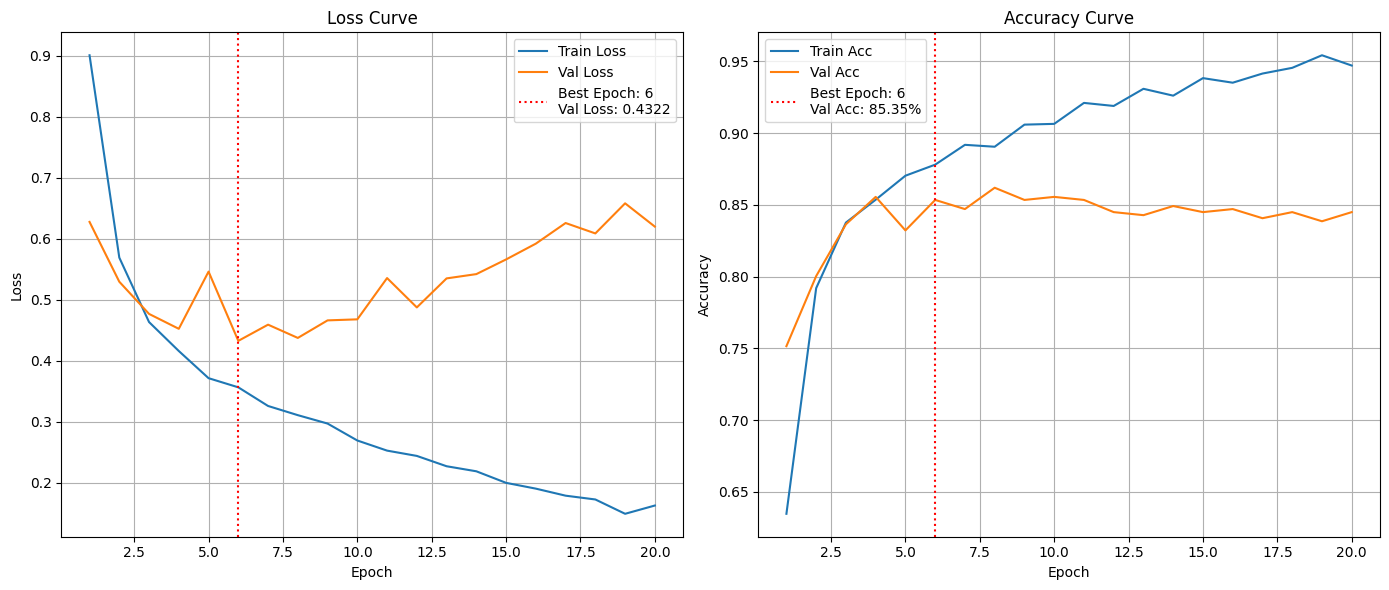

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       190
           1       0.83      0.72      0.77        94
           2       0.87      0.75      0.80        60
           3       0.83      0.88      0.85       127

    accuracy                           0.85       471
   macro avg       0.85      0.82      0.83       471
weighted avg       0.85      0.85      0.85       471



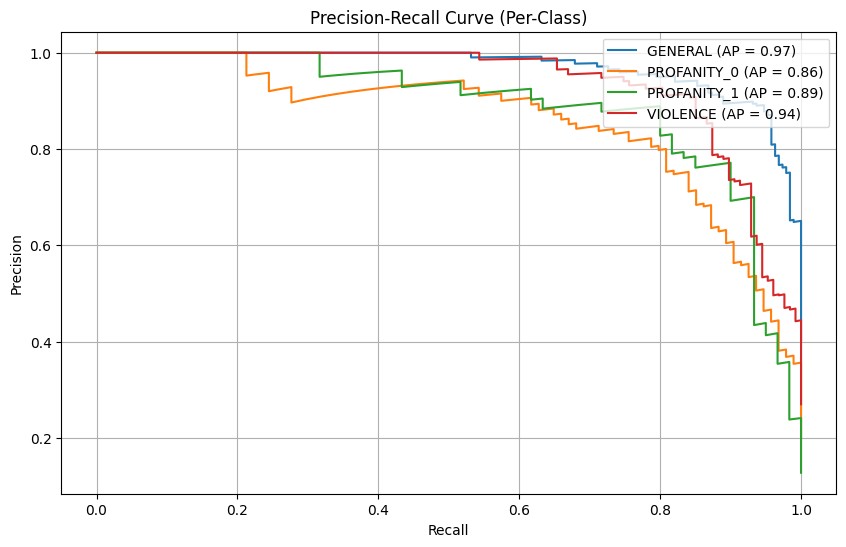

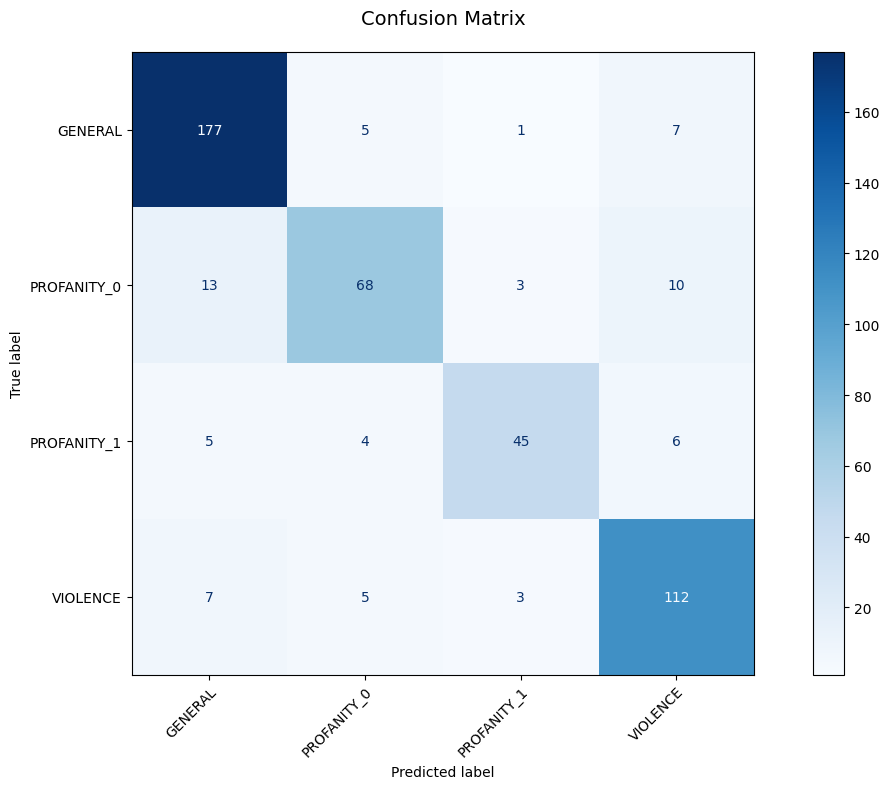

In [31]:
finetuned_model = model_train(finetuned_model, finetuned_criterion, finetuned_optimizer, finetuned_train_loader, finetuned_val_loader,save_name="fasttext_finetuned", version_control=True,epochs= 20)
finetuned_report = evaluate_model(finetuned_model, finetuned_val_loader, label_map,  version_control= True, save_name = "fasttext_finetuned")

## Also, let's check cost sensitive models with class weights

In [36]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for i in range(len(scratch_train)):
    _, _, label = scratch_train[i]  
    labels.append(label.item()) 

labels = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(labels),  # Unique classes in training labels
    y=labels  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)

class_weights_tensor = class_weights_tensor.to(device)

Normalized Class Weights: tensor([0.1307, 0.2639, 0.4114, 0.1940])


Epoch 1/20 | Train Loss: 0.8750 | Val Loss: 0.6938 | Train Acc: 68.15% | Val Acc: 74.52%
Epoch 2/20 | Train Loss: 0.6030 | Val Loss: 0.6431 | Train Acc: 78.83% | Val Acc: 80.47%
Epoch 3/20 | Train Loss: 0.5506 | Val Loss: 0.6149 | Train Acc: 80.77% | Val Acc: 81.32%
Epoch 4/20 | Train Loss: 0.5307 | Val Loss: 0.6110 | Train Acc: 82.50% | Val Acc: 81.32%
Epoch 5/20 | Train Loss: 0.5104 | Val Loss: 0.6103 | Train Acc: 82.74% | Val Acc: 82.38%
Epoch 6/20 | Train Loss: 0.4912 | Val Loss: 0.6293 | Train Acc: 83.19% | Val Acc: 81.10%
Epoch 7/20 | Train Loss: 0.4718 | Val Loss: 0.6036 | Train Acc: 84.22% | Val Acc: 81.95%
Epoch 8/20 | Train Loss: 0.4614 | Val Loss: 0.6097 | Train Acc: 84.22% | Val Acc: 83.65%
Epoch 9/20 | Train Loss: 0.4421 | Val Loss: 0.5911 | Train Acc: 85.44% | Val Acc: 83.23%
Epoch 10/20 | Train Loss: 0.4321 | Val Loss: 0.6045 | Train Acc: 85.76% | Val Acc: 82.59%
Epoch 11/20 | Train Loss: 0.4297 | Val Loss: 0.5609 | Train Acc: 85.90% | Val Acc: 82.38%
Epoch 12/20 | Train

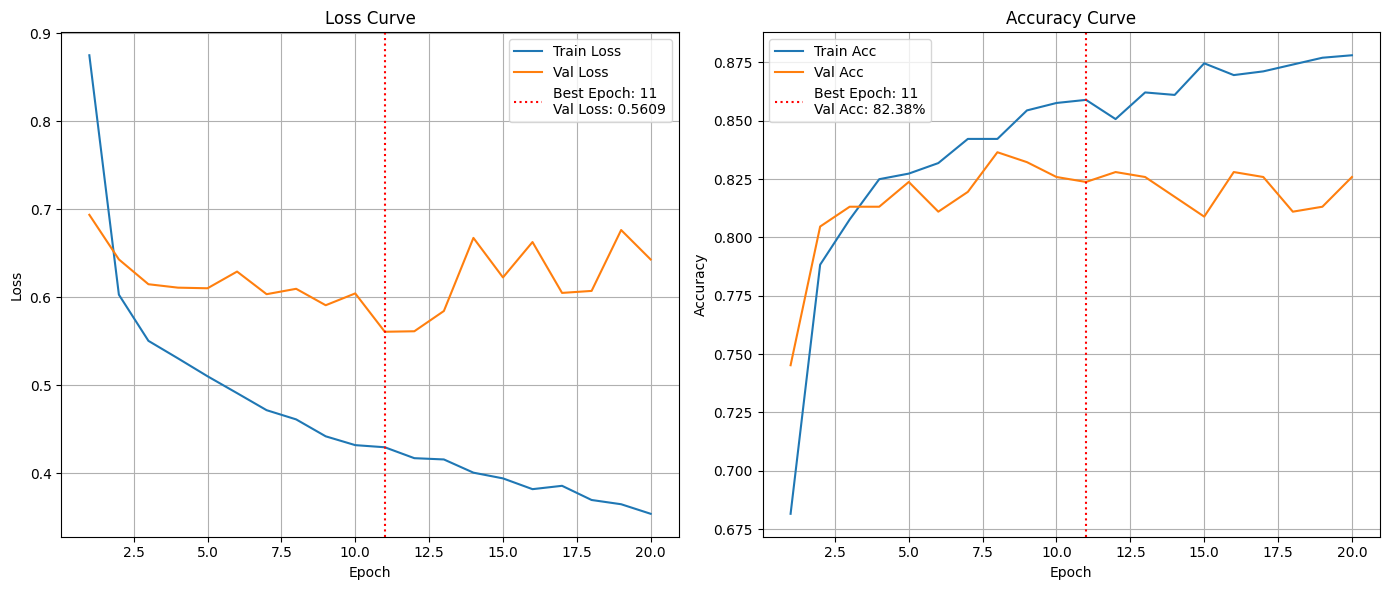

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       190
           1       0.71      0.73      0.72        94
           2       0.84      0.77      0.80        60
           3       0.82      0.80      0.81       127

    accuracy                           0.82       471
   macro avg       0.81      0.80      0.81       471
weighted avg       0.82      0.82      0.82       471



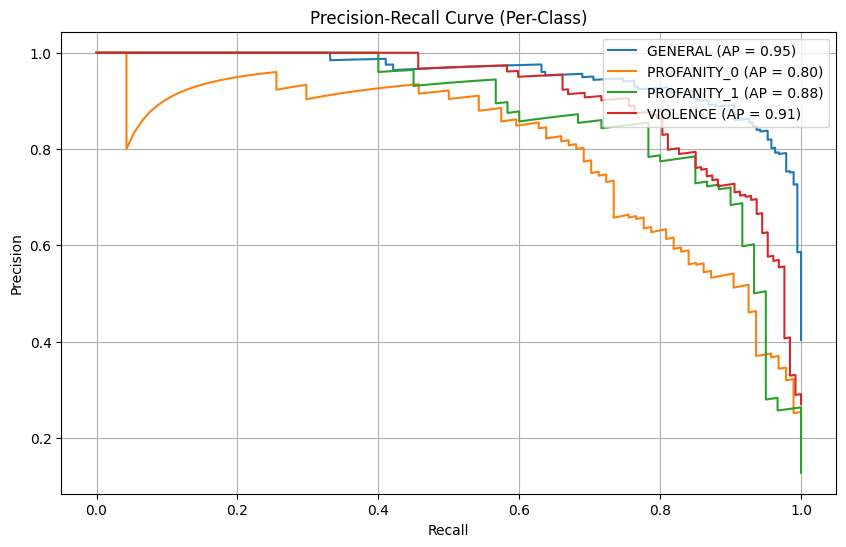

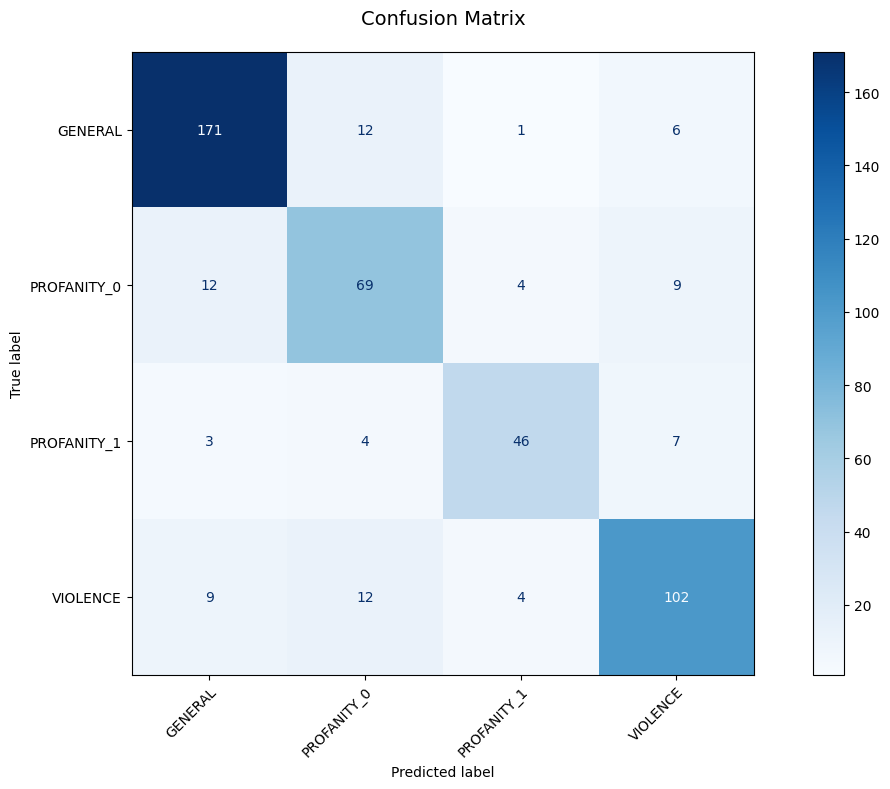

In [41]:
cs_scratch_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

cs_scratch_model = BiLSTMAttention(
    input_dim=cs_scratch_params["input_dim"],
    hidden_dim=cs_scratch_params["hidden_dim"],
    num_classes=cs_scratch_params["num_classes"]
).to(device)

# Loss function
cs_scratch_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_scratch_optimizer = torch.optim.AdamW(
    cs_scratch_model.parameters(),
    lr=cs_scratch_params["lr"],
    weight_decay=cs_scratch_params["weight_decay"]
)

cs_scratch_model = model_train(cs_scratch_model, cs_scratch_criterion, cs_scratch_optimizer, scratch_train_loader, scratch_val_loader,save_name="cs_fasttext_scratch", version_control=True,epochs= 20)
cs_scratch_report = evaluate_model(cs_scratch_model, scratch_val_loader, label_map,  version_control= True, save_name = "cs_fasttext_scratch")

Epoch 1/20 | Train Loss: 1.0830 | Val Loss: 1.8803 | Train Acc: 56.04% | Val Acc: 40.76%
Epoch 2/20 | Train Loss: 0.7055 | Val Loss: 2.4061 | Train Acc: 75.59% | Val Acc: 40.76%
Epoch 3/20 | Train Loss: 0.5921 | Val Loss: 2.7432 | Train Acc: 80.50% | Val Acc: 40.55%
Epoch 4/20 | Train Loss: 0.5185 | Val Loss: 2.9504 | Train Acc: 83.05% | Val Acc: 39.92%
Epoch 5/20 | Train Loss: 0.4702 | Val Loss: 3.3914 | Train Acc: 84.62% | Val Acc: 40.13%
Epoch 6/20 | Train Loss: 0.4336 | Val Loss: 3.7568 | Train Acc: 86.22% | Val Acc: 38.00%
Epoch 7/20 | Train Loss: 0.3862 | Val Loss: 3.9118 | Train Acc: 87.33% | Val Acc: 40.34%
Epoch 8/20 | Train Loss: 0.3624 | Val Loss: 3.8101 | Train Acc: 88.53% | Val Acc: 40.76%
Epoch 9/20 | Train Loss: 0.3472 | Val Loss: 4.1090 | Train Acc: 88.82% | Val Acc: 39.70%
Epoch 10/20 | Train Loss: 0.3207 | Val Loss: 4.1962 | Train Acc: 89.46% | Val Acc: 41.40%
Epoch 11/20 | Train Loss: 0.3013 | Val Loss: 4.5198 | Train Acc: 90.23% | Val Acc: 41.83%
Epoch 12/20 | Train

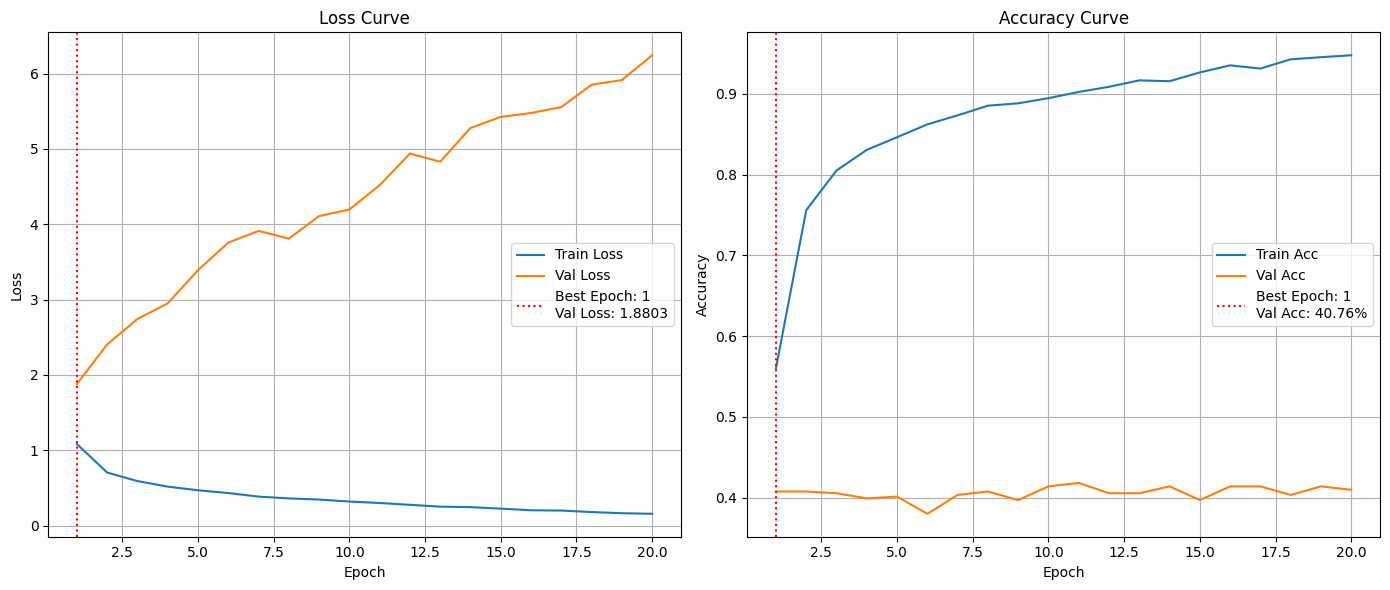

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.73       284
           1       0.11      0.20      0.14        60
           2       0.14      0.06      0.08       127
           3       0.00      0.00      0.00         0

    accuracy                           0.41       471
   macro avg       0.29      0.22      0.24       471
weighted avg       0.61      0.41      0.48       471



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No

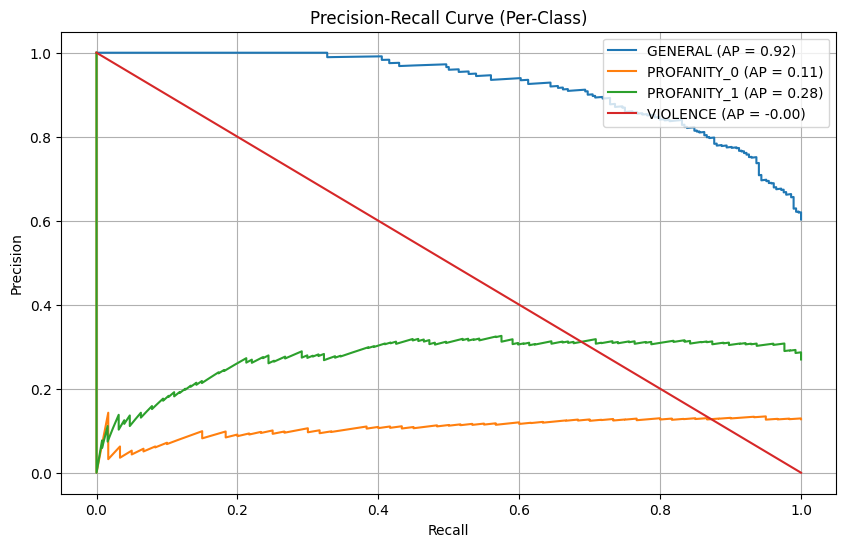

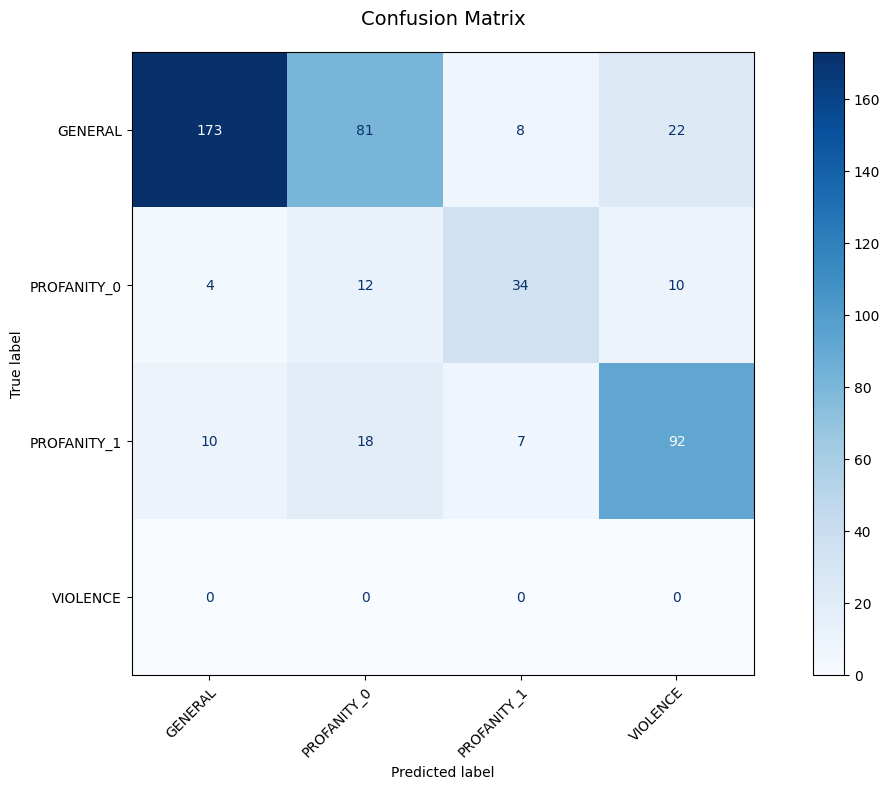

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# pretrained
cs_pretrained_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

cs_pretrained_model = BiLSTMAttention(
    input_dim=cs_pretrained_params["input_dim"],
    hidden_dim=cs_pretrained_params["hidden_dim"],
    num_classes=cs_pretrained_params["num_classes"]
).to(device)

# Loss function
cs_pretrained_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_pretrained_optimizer = torch.optim.AdamW(
    cs_pretrained_model.parameters(),
    lr=cs_pretrained_params["lr"],
    weight_decay=cs_pretrained_params["weight_decay"]
)

cs_pretrained_model = model_train(cs_pretrained_model, cs_pretrained_criterion, cs_pretrained_optimizer, pretrained_train_loader, pretrained_val_loader,save_name="cs_fasttext_pretrained", version_control=True,epochs= 20)
cs_pretrained_report = evaluate_model(cs_pretrained_model, pretrained_val_loader, label_map,  version_control= True, save_name = "cs_fasttext_pretrained")

Epoch 1/20 | Train Loss: 1.0139 | Val Loss: 0.7516 | Train Acc: 59.73% | Val Acc: 74.73%
Epoch 2/20 | Train Loss: 0.6368 | Val Loss: 0.5864 | Train Acc: 77.13% | Val Acc: 81.53%
Epoch 3/20 | Train Loss: 0.5089 | Val Loss: 0.5586 | Train Acc: 81.65% | Val Acc: 82.80%
Epoch 4/20 | Train Loss: 0.4506 | Val Loss: 0.5321 | Train Acc: 84.94% | Val Acc: 83.23%
Epoch 5/20 | Train Loss: 0.4054 | Val Loss: 0.4990 | Train Acc: 86.22% | Val Acc: 83.65%
Epoch 6/20 | Train Loss: 0.3848 | Val Loss: 0.4972 | Train Acc: 87.01% | Val Acc: 84.93%
Epoch 7/20 | Train Loss: 0.3474 | Val Loss: 0.5511 | Train Acc: 87.65% | Val Acc: 84.93%
Epoch 8/20 | Train Loss: 0.3324 | Val Loss: 0.5295 | Train Acc: 88.84% | Val Acc: 85.99%
Epoch 9/20 | Train Loss: 0.3131 | Val Loss: 0.5247 | Train Acc: 90.15% | Val Acc: 85.35%
Epoch 10/20 | Train Loss: 0.2893 | Val Loss: 0.5665 | Train Acc: 90.81% | Val Acc: 86.41%
Epoch 11/20 | Train Loss: 0.2788 | Val Loss: 0.5334 | Train Acc: 90.68% | Val Acc: 85.77%
Epoch 12/20 | Train

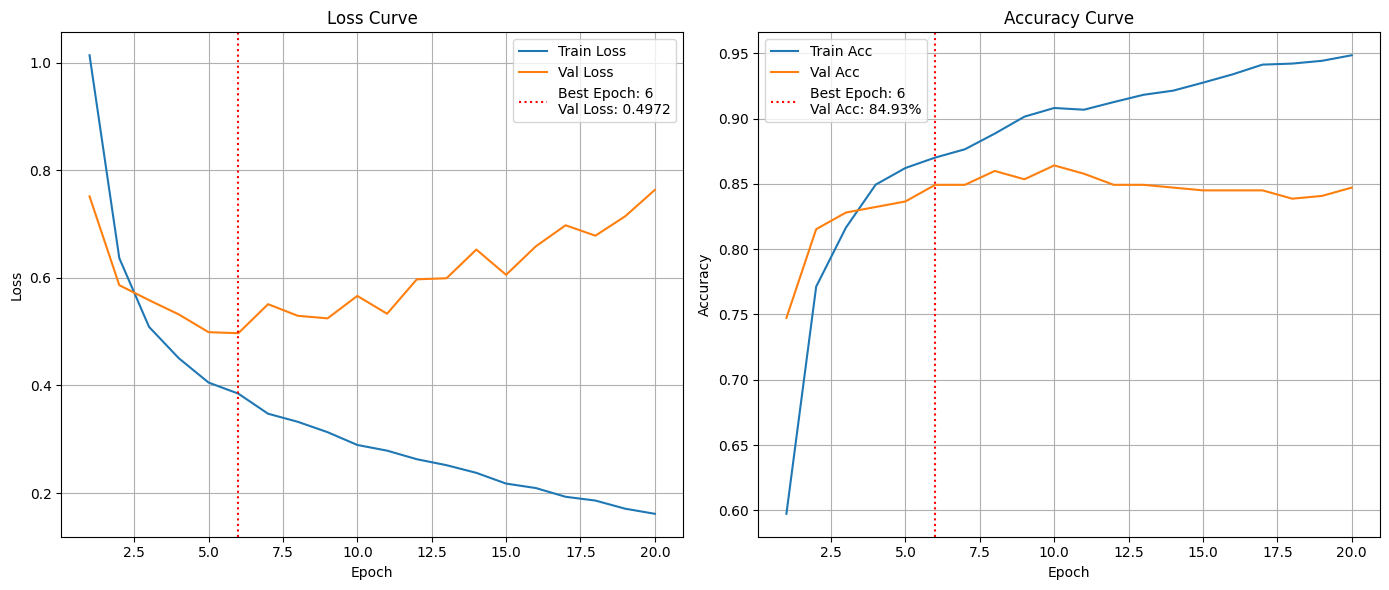

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       190
           1       0.74      0.85      0.79        94
           2       0.87      0.80      0.83        60
           3       0.87      0.81      0.84       127

    accuracy                           0.85       471
   macro avg       0.84      0.84      0.84       471
weighted avg       0.85      0.85      0.85       471



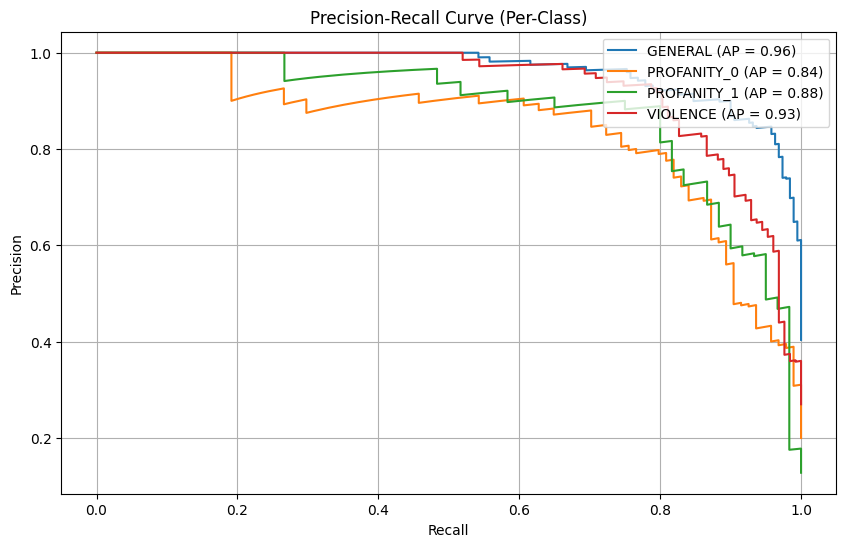

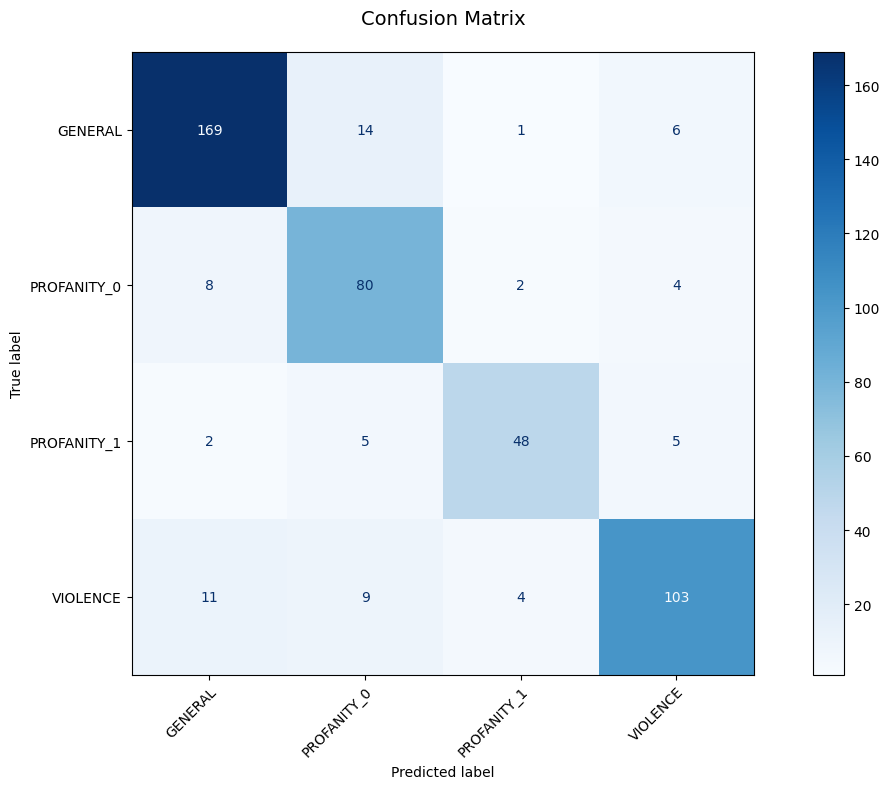

In [43]:
# finetuned
cs_finetuned_params = {
    "input_dim" : 300,
    "hidden_dim" : 148,
    "num_classes" : 4,
    "lr" : 1e-4,
    "weight_decay" : 1e-5,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16
}

cs_finetuned_model = BiLSTMAttention(
    input_dim=cs_finetuned_params["input_dim"],
    hidden_dim=cs_finetuned_params["hidden_dim"],
    num_classes=cs_finetuned_params["num_classes"]
).to(device)

# Loss function
cs_finetuned_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer using unpacking
cs_finetuned_optimizer = torch.optim.AdamW(
    cs_finetuned_model.parameters(),
    lr=cs_finetuned_params["lr"],
    weight_decay=cs_finetuned_params["weight_decay"]
)

cs_finetuned_model = model_train(cs_finetuned_model, cs_finetuned_criterion, cs_finetuned_optimizer, finetuned_train_loader, finetuned_val_loader,save_name="cs_fasttext_finetuned", version_control=True,epochs= 20)
cs_finetuned_report = evaluate_model(cs_finetuned_model, finetuned_val_loader, label_map,  version_control= True, save_name = "cs_fasttext_finetuned")

## MLFlow logging

In [45]:
!pip install -q dagshub mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

In [46]:
import dagshub
dagshub.init(repo_owner='tamangangel2057', repo_name='Nephased', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4ca88f45-c416-4329-a053-36a3477eca4a&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=109b9d573eb47bc27f4b5b1b670a609484672c001157ffe8754edcc3dbb15606




Accessing as tamangangel2057

Initialized MLflow to track repo "tamangangel2057/Nephased"

Repository tamangangel2057/Nephased initialized!

In [49]:
import mlflow

# Initialize Mlflow experiment
experiment_id = mlflow.create_experiment("Word_embedding_bilstm")
print(experiment_id)

0


In [51]:
# Start the run

torch.save(scratch_model.state_dict(), "scratch_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_scratch"):
    mlflow.log_params(scratch_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": scratch_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": scratch_report["0"]["precision"],
        "recall_0": scratch_report["0"]["recall"],
        "f1_0": scratch_report["0"]["f1-score"],
        "support_0": scratch_report["0"]["support"],

        "precision_1": scratch_report["1"]["precision"],
        "recall_1": scratch_report["1"]["recall"],
        "f1_1": scratch_report["1"]["f1-score"],
        "support_1": scratch_report["1"]["support"],

        "precision_2": scratch_report["2"]["precision"],
        "recall_2": scratch_report["2"]["recall"],
        "f1_2": scratch_report["2"]["f1-score"],
        "support_2": scratch_report["2"]["support"],

        "precision_3": scratch_report["3"]["precision"],
        "recall_3": scratch_report["3"]["recall"],
        "f1_3": scratch_report["3"]["f1-score"],
        "support_3": scratch_report["3"]["support"],

        # Macro average
        "macro_precision": scratch_report["macro avg"]["precision"],
        "macro_recall": scratch_report["macro avg"]["recall"],
        "macro_f1": scratch_report["macro avg"]["f1-score"],
        "macro_support": scratch_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": scratch_report["weighted avg"]["precision"],
        "weighted_recall": scratch_report["weighted avg"]["recall"],
        "weighted_f1": scratch_report["weighted avg"]["f1-score"],
        "weighted_support": scratch_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/fasttext_scratch_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_scratch_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_scratch_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("scratch_model_state_dict.pt", artifact_path="model")

🏃 View run Fasttext_scratch at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/dc4ba2616e554364819633c56d6278e0
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [52]:
# Start the run

torch.save(pretrained_model.state_dict(), "pretrained_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_pretrained"):
    mlflow.log_params(pretrained_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": pretrained_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": pretrained_report["0"]["precision"],
        "recall_0": pretrained_report["0"]["recall"],
        "f1_0": pretrained_report["0"]["f1-score"],
        "support_0": pretrained_report["0"]["support"],

        "precision_1": pretrained_report["1"]["precision"],
        "recall_1": pretrained_report["1"]["recall"],
        "f1_1": pretrained_report["1"]["f1-score"],
        "support_1": pretrained_report["1"]["support"],

        "precision_2": pretrained_report["2"]["precision"],
        "recall_2": pretrained_report["2"]["recall"],
        "f1_2": pretrained_report["2"]["f1-score"],
        "support_2": pretrained_report["2"]["support"],

        "precision_3": pretrained_report["3"]["precision"],
        "recall_3": pretrained_report["3"]["recall"],
        "f1_3": pretrained_report["3"]["f1-score"],
        "support_3": pretrained_report["3"]["support"],

        # Macro average
        "macro_precision": pretrained_report["macro avg"]["precision"],
        "macro_recall": pretrained_report["macro avg"]["recall"],
        "macro_f1": pretrained_report["macro avg"]["f1-score"],
        "macro_support": pretrained_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": pretrained_report["weighted avg"]["precision"],
        "weighted_recall": pretrained_report["weighted avg"]["recall"],
        "weighted_f1": pretrained_report["weighted avg"]["f1-score"],
        "weighted_support": pretrained_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/fasttext_pretrained_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_pretrained_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_pretrained_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("pretrained_model_state_dict.pt", artifact_path="model")

🏃 View run Fasttext_pretrained at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/8e7e3d04ec7e4693a1e4f372e7c73dd1
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [53]:
# Start the run

torch.save(finetuned_model.state_dict(), "finetuned_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_finetuned"):
    mlflow.log_params(finetuned_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": finetuned_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": finetuned_report["0"]["precision"],
        "recall_0": finetuned_report["0"]["recall"],
        "f1_0": finetuned_report["0"]["f1-score"],
        "support_0": finetuned_report["0"]["support"],

        "precision_1": finetuned_report["1"]["precision"],
        "recall_1": finetuned_report["1"]["recall"],
        "f1_1": finetuned_report["1"]["f1-score"],
        "support_1": finetuned_report["1"]["support"],

        "precision_2": finetuned_report["2"]["precision"],
        "recall_2": finetuned_report["2"]["recall"],
        "f1_2": finetuned_report["2"]["f1-score"],
        "support_2": finetuned_report["2"]["support"],

        "precision_3": finetuned_report["3"]["precision"],
        "recall_3": finetuned_report["3"]["recall"],
        "f1_3": finetuned_report["3"]["f1-score"],
        "support_3": finetuned_report["3"]["support"],

        # Macro average
        "macro_precision": finetuned_report["macro avg"]["precision"],
        "macro_recall": finetuned_report["macro avg"]["recall"],
        "macro_f1": finetuned_report["macro avg"]["f1-score"],
        "macro_support": finetuned_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": finetuned_report["weighted avg"]["precision"],
        "weighted_recall": finetuned_report["weighted avg"]["recall"],
        "weighted_f1": finetuned_report["weighted avg"]["f1-score"],
        "weighted_support": finetuned_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/fasttext_finetuned_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_finetuned_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/fasttext_finetuned_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("finetuned_model_state_dict.pt", artifact_path="model")

🏃 View run Fasttext_finetuned at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/0a4eeb165be441afbb98bb141ab63ccc
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


### saving cs models

In [55]:
# Start the run

torch.save(cs_scratch_model.state_dict(), "cs_scratch_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_cs_scratch"):
    mlflow.log_params(cs_scratch_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_scratch_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_scratch_report["0"]["precision"],
        "recall_0": cs_scratch_report["0"]["recall"],
        "f1_0": cs_scratch_report["0"]["f1-score"],
        "support_0": cs_scratch_report["0"]["support"],

        "precision_1": cs_scratch_report["1"]["precision"],
        "recall_1": cs_scratch_report["1"]["recall"],
        "f1_1": cs_scratch_report["1"]["f1-score"],
        "support_1": cs_scratch_report["1"]["support"],

        "precision_2": cs_scratch_report["2"]["precision"],
        "recall_2": cs_scratch_report["2"]["recall"],
        "f1_2": cs_scratch_report["2"]["f1-score"],
        "support_2": cs_scratch_report["2"]["support"],

        "precision_3": cs_scratch_report["3"]["precision"],
        "recall_3": cs_scratch_report["3"]["recall"],
        "f1_3": cs_scratch_report["3"]["f1-score"],
        "support_3": cs_scratch_report["3"]["support"],

        # Macro average
        "macro_precision": cs_scratch_report["macro avg"]["precision"],
        "macro_recall": cs_scratch_report["macro avg"]["recall"],
        "macro_f1": cs_scratch_report["macro avg"]["f1-score"],
        "macro_support": cs_scratch_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_scratch_report["weighted avg"]["precision"],
        "weighted_recall": cs_scratch_report["weighted avg"]["recall"],
        "weighted_f1": cs_scratch_report["weighted avg"]["f1-score"],
        "weighted_support": cs_scratch_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_fasttext_scratch_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_scratch_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_scratch_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_scratch_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Fasttext_cs_scratch at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/98bbf3c98c70474f8fcaf8269632aab6
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [56]:
# Start the run

torch.save(cs_pretrained_model.state_dict(), "cs_pretrained_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_cs_pretrained"):
    mlflow.log_params(cs_pretrained_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_pretrained_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_pretrained_report["0"]["precision"],
        "recall_0": cs_pretrained_report["0"]["recall"],
        "f1_0": cs_pretrained_report["0"]["f1-score"],
        "support_0": cs_pretrained_report["0"]["support"],

        "precision_1": cs_pretrained_report["1"]["precision"],
        "recall_1": cs_pretrained_report["1"]["recall"],
        "f1_1": cs_pretrained_report["1"]["f1-score"],
        "support_1": cs_pretrained_report["1"]["support"],

        "precision_2": cs_pretrained_report["2"]["precision"],
        "recall_2": cs_pretrained_report["2"]["recall"],
        "f1_2": cs_pretrained_report["2"]["f1-score"],
        "support_2": cs_pretrained_report["2"]["support"],

        "precision_3": cs_pretrained_report["3"]["precision"],
        "recall_3": cs_pretrained_report["3"]["recall"],
        "f1_3": cs_pretrained_report["3"]["f1-score"],
        "support_3": cs_pretrained_report["3"]["support"],

        # Macro average
        "macro_precision": cs_pretrained_report["macro avg"]["precision"],
        "macro_recall": cs_pretrained_report["macro avg"]["recall"],
        "macro_f1": cs_pretrained_report["macro avg"]["f1-score"],
        "macro_support": cs_pretrained_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_pretrained_report["weighted avg"]["precision"],
        "weighted_recall": cs_pretrained_report["weighted avg"]["recall"],
        "weighted_f1": cs_pretrained_report["weighted avg"]["f1-score"],
        "weighted_support": cs_pretrained_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_fasttext_pretrained_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_pretrained_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_pretrained_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_pretrained_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Fasttext_cs_pretrained at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/608827522a204faea77ff20dd1b3b1d3
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0


In [57]:
# Start the run

torch.save(cs_finetuned_model.state_dict(), "cs_finetuned_model_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Fasttext_cs_finetuned"):
    mlflow.log_params(cs_finetuned_params)
    mlflow.log_param("drop_out",0.5)
    mlflow.log_metrics({
        # Global accuracy
        "accuracy": cs_finetuned_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": cs_finetuned_report["0"]["precision"],
        "recall_0": cs_finetuned_report["0"]["recall"],
        "f1_0": cs_finetuned_report["0"]["f1-score"],
        "support_0": cs_finetuned_report["0"]["support"],

        "precision_1": cs_finetuned_report["1"]["precision"],
        "recall_1": cs_finetuned_report["1"]["recall"],
        "f1_1": cs_finetuned_report["1"]["f1-score"],
        "support_1": cs_finetuned_report["1"]["support"],

        "precision_2": cs_finetuned_report["2"]["precision"],
        "recall_2": cs_finetuned_report["2"]["recall"],
        "f1_2": cs_finetuned_report["2"]["f1-score"],
        "support_2": cs_finetuned_report["2"]["support"],

        "precision_3": cs_finetuned_report["3"]["precision"],
        "recall_3": cs_finetuned_report["3"]["recall"],
        "f1_3": cs_finetuned_report["3"]["f1-score"],
        "support_3": cs_finetuned_report["3"]["support"],

        # Macro average
        "macro_precision": cs_finetuned_report["macro avg"]["precision"],
        "macro_recall": cs_finetuned_report["macro avg"]["recall"],
        "macro_f1": cs_finetuned_report["macro avg"]["f1-score"],
        "macro_support": cs_finetuned_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": cs_finetuned_report["weighted avg"]["precision"],
        "weighted_recall": cs_finetuned_report["weighted avg"]["recall"],
        "weighted_f1": cs_finetuned_report["weighted avg"]["f1-score"],
        "weighted_support": cs_finetuned_report["weighted avg"]["support"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/cs_fasttext_finetuned_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_finetuned_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/cs_fasttext_finetuned_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("cs_finetuned_model_state_dict.pt", artifact_path="model")

    # Saving the class weights as params too
    for idx, weight in enumerate(class_weights_tensor.tolist()):
        mlflow.log_param(f"class_weight_{idx}", weight)

🏃 View run Fasttext_cs_finetuned at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0/runs/8a590255eb5043e0aa0b735c117ec0df
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/0
